# Tweet Classification for Limportant


### Try to put the tweet into one of 13 categories by machine learning

In [87]:
import os
print(os.listdir("./data"))

['.DS_Store', 'tweet_extract.csv', 'Classeur1.csv', 'test2.csv', 'data_export_2018-05-29.csv', '.Rapp.history']


In [88]:
import pandas as pd
import numpy as np

In [110]:
# Loading data
all_data = pd.read_csv("./data/data_export_2018-05-29.csv", engine='python')

In [111]:
all_data.head()

,text,category_id
0,Simone Veil : désormais une station du métro p...,4
1,«Grand monsieur» ou «clientéliste»: avis contr...,4
2,Corse : saccage volontaire de 1600 clémentinie...,4
3,NaN,4
4,Un ordinateur meilleur que les dermatologues p...,5


we drop the nan rows.

In [112]:
all_data.dropna(subset=['text'],inplace=True)

In [113]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18717 entries, 0 to 19998
Data columns (total 2 columns):
text           18717 non-null object
category_id    18717 non-null int64
dtypes: int64(1), object(1)
memory usage: 438.7+ KB


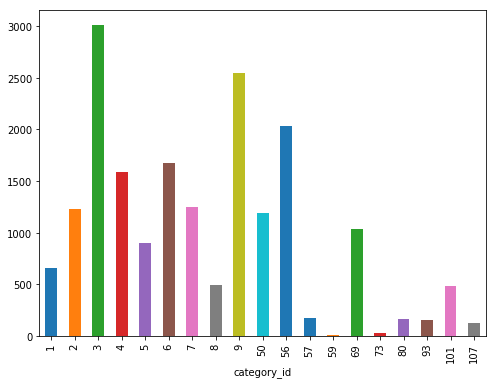

In [114]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
all_data.groupby('category_id').text.count().plot.bar(ylim=0)
plt.show()

# 1. Preparing data

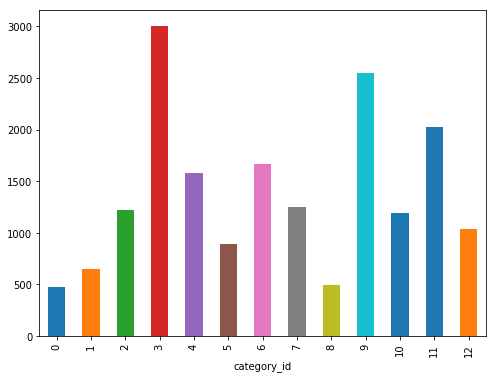

In [115]:
# drop the partenaires, which are 57,59,73,80,93,107
# tranform category_id into [0,12] 

all_data.loc[all_data['category_id'] == 57, 'text'] = np.nan
all_data.loc[all_data['category_id'] == 59, 'text'] = np.nan
all_data.loc[all_data['category_id'] == 73, 'text'] = np.nan
all_data.loc[all_data['category_id'] == 80, 'text'] = np.nan
all_data.loc[all_data['category_id'] == 93, 'text'] = np.nan
all_data.loc[all_data['category_id'] == 107, 'text'] = np.nan

all_data.dropna(subset=['text'],inplace=True)

all_data.loc[all_data['category_id'] == 50, 'category_id'] = 10
all_data.loc[all_data['category_id'] == 56, 'category_id'] = 11
all_data.loc[all_data['category_id'] == 69, 'category_id'] = 12
all_data.loc[all_data['category_id'] == 101, 'category_id'] = 0

fig = plt.figure(figsize=(8,6))
all_data.groupby('category_id').text.count().plot.bar(ylim=0)
plt.show()

In [116]:
# Create stopWords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_fr = set(stopwords.words('french'))
stopWords_en = set(stopwords.words('english'))
stopWords = stopWords_en | stopWords_fr | set(':')
print(stopWords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enzoliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'eût', 'tes', 'most', 'am', 'their', 'are', 'qui', 'seront', 'same', 'était', 'elle', 'ayantes', 'serez', 'fût', 'yourselves', 'this', 'doing', 'leur', 'avions', 'ne', 'ton', 'aurez', 'after', 'eûtes', 'sa', "won't", 'haven', 'some', 'doesn', "it's", 'es', 'aurions', 'eussions', 'aient', 'eussent', 'just', "should've", 'only', 'étions', 'few', 'eus', "that'll", 'then', 'sois', 'ce', 'theirs', 'below', 'these', 'eurent', 'eue', 'further', 'étées', 'te', 'eu', 'auras', 'étantes', 'ces', 'over', 'as', 'for', 'its', 'while', 'where', 'aurons', 'eut', 'through', "you'll", 'eues', 'que', 'serai', 'auront', 'yours', 'êtes', 'aura', 'be', 'and', "aren't", 'in', 'aurais', 'à', 'ai', 'sont', 'par', 'fus', 'vos', 'n', 'been', 'such', 'hers', 'other', 'or', 'avec', 'o', "needn't", 'above', 'he', 'furent', "doesn't", 'again', 'were', 'eusse', 'j', 'ses', '

In [117]:
# Create Features and Labels
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer( analyzer=u'word', stop_words=stopWords, ngram_range = (1,2))
tfidf_transformer = TfidfTransformer(norm='l2', sublinear_tf=True)

# First, we transform the text into vector, which show how many times each word shows
features_counts = count_vect.fit_transform(all_data['text'])

# Second, we add weight for each word. It conside 2 part.
# Part 1, Term Frequency，TF, shows how many times each words shows in the text
# Part 2, Inverse Document Frequency，IDF, log(nb_of_text_has_the_word/nb_of_all_text)
# tfidf = tf-idf(q, d) = sum { i = 1..k | tf-idf(w[i], d) } = sum { i = 1..k | tf(w[i], d) * idf(w[i]) }
features = tfidf_transformer.fit_transform(features_counts)

labels = all_data['category_id']

# 2. Modeling

### 2.1 Model section

In [176]:
# Model Section
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import cross_val_score,StratifiedKFold

# choose Multiclass as One-Vs-All in sklearn for its strong performance in our project
models = [
    Perceptron(random_state=0,max_iter=5),
    SGDClassifier(random_state=0,max_iter=5),
    PassiveAggressiveClassifier(random_state=0,max_iter=5),
    LinearSVC(random_state=0),
    LogisticRegression(random_state=0),
]
CV = StratifiedKFold(n_splits=5)
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                      0.669447
LogisticRegression             0.516849
PassiveAggressiveClassifier    0.669835
Perceptron                     0.608124
SGDClassifier                  0.666957
Name: accuracy, dtype: float64

We can see LinearSVC, PassiveAggressiveClassifier, SGDClassifier do a great job, we will use LinearSVC to build our model as a first try.

### 2.2 Model building

In [123]:
# we use LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(all_data['text'], all_data['category_id'], test_size=0.2,random_state = 0)

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = LinearSVC().fit(X_train_tfidf, y_train)

y_pre = clf.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test)))
print(metrics.classification_report(y_test, y_pre))

             precision    recall  f1-score   support

          0       0.79      0.86      0.83       107
          1       0.57      0.62      0.59       118
          2       0.66      0.58      0.62       254
          3       0.63      0.78      0.70       575
          4       0.69      0.71      0.70       323
          5       0.73      0.53      0.61       193
          6       0.73      0.64      0.68       327
          7       0.69      0.69      0.69       247
          8       0.90      0.70      0.79       106
          9       0.57      0.58      0.57       522
         10       0.82      0.74      0.78       243
         11       0.68      0.69      0.69       396
         12       0.83      0.84      0.83       203

avg / total       0.69      0.68      0.68      3614



- Precision = (the number of right tweets the model puts in this category) / (all the tweets the model puts in this category)

- Recall = (the number of right tweets of this category) / (all the right tweets in this category)

It's better to check the full-score, we know the model scores 0.68/1.00. Just so so. 

In [170]:
# simple try
word_count = count_vect.transform(["Paris : sur les 302 stations seulement 4 portent le nom d'une femme"])
word_tfidf = tfidf_transformer.fit_transform(word_count)
print(word_tfidf)
print(clf.predict(word_tfidf))

  (0, 261939)	0.31622776601683794
  (0, 252574)	0.31622776601683794
  (0, 213284)	0.31622776601683794
  (0, 213281)	0.31622776601683794
  (0, 198258)	0.31622776601683794
  (0, 198012)	0.31622776601683794
  (0, 187034)	0.31622776601683794
  (0, 186998)	0.31622776601683794
  (0, 153607)	0.31622776601683794
  (0, 107552)	0.31622776601683794
[4]


#### Now, let's try PassiveAggressiveClassifier and SGDClassifier, which are also not bad

In [178]:
# PassiveAggressiveClassifier
clf =PassiveAggressiveClassifier(max_iter=5).fit(X_train_tfidf, y_train)

y_pre = clf.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test)))
print(metrics.classification_report(y_test, y_pre))

             precision    recall  f1-score   support

          0       0.78      0.84      0.81       107
          1       0.56      0.59      0.58       118
          2       0.63      0.57      0.60       254
          3       0.63      0.76      0.69       575
          4       0.69      0.70      0.70       323
          5       0.73      0.56      0.64       193
          6       0.73      0.65      0.69       327
          7       0.69      0.69      0.69       247
          8       0.88      0.72      0.79       106
          9       0.57      0.57      0.57       522
         10       0.81      0.75      0.78       243
         11       0.68      0.68      0.68       396
         12       0.81      0.84      0.83       203

avg / total       0.68      0.68      0.68      3614



In [179]:
# SGDClassifier
clf = SGDClassifier(max_iter=5).fit(X_train_tfidf, y_train)

y_pre = clf.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test)))
print(metrics.classification_report(y_test, y_pre))

             precision    recall  f1-score   support

          0       0.76      0.93      0.84       107
          1       0.57      0.61      0.59       118
          2       0.65      0.56      0.60       254
          3       0.63      0.77      0.69       575
          4       0.66      0.69      0.67       323
          5       0.72      0.53      0.61       193
          6       0.73      0.65      0.69       327
          7       0.68      0.70      0.69       247
          8       0.90      0.75      0.81       106
          9       0.61      0.54      0.57       522
         10       0.82      0.75      0.78       243
         11       0.66      0.71      0.68       396
         12       0.81      0.86      0.83       203

avg / total       0.68      0.68      0.68      3614



In [151]:
# try the most popular model in kaggle xgboost
import xgboost as xgb

xg_train = xgb.DMatrix(X_train_tfidf, label=y_train)
xg_test = xgb.DMatrix(tfidf_transformer.fit_transform(count_vect.transform(X_test)), label=y_test)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.01
param['max_depth'] = 6
param['silent'] = 1
param['num_class'] = 13

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 10
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
y_pre = bst.predict(xg_test)
print(metrics.classification_report(y_test, y_pre))


[0]	train-merror:0.57988	test-merror:0.622025
[1]	train-merror:0.575728	test-merror:0.617598
[2]	train-merror:0.574068	test-merror:0.617322
[3]	train-merror:0.570539	test-merror:0.614001
[4]	train-merror:0.570331	test-merror:0.613448
[5]	train-merror:0.568532	test-merror:0.608467
[6]	train-merror:0.564174	test-merror:0.608744
[7]	train-merror:0.559538	test-merror:0.604593
[8]	train-merror:0.557116	test-merror:0.600166
[9]	train-merror:0.552757	test-merror:0.595185
             precision    recall  f1-score   support

          0       0.54      0.89      0.67       107
          1       0.39      0.48      0.43       118
          2       0.59      0.26      0.36       254
          3       0.23      0.72      0.35       575
          4       0.56      0.35      0.43       323
          5       0.58      0.29      0.39       193
          6       0.63      0.20      0.31       327
          7       0.62      0.39      0.48       247
          8       0.75      0.42      0.54       106


ok, it's terrible in our project, we leave it alone and move on !

### 2.3 Hyperparameter tunning for best models

It seems the three models have the score 0.66 in Model Selection. I will use Gridsearch to find the best hyperparameter for the models.

In [152]:
from sklearn.model_selection import GridSearchCV

In [171]:
# LinearSVC

LSVC = LinearSVC()
# C : Penalty parameter C of the error term
param_grid = {
    "C":[0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
}

gsLSVC = GridSearchCV(LSVC, param_grid = param_grid, cv=CV, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLSVC.fit(X_train_tfidf, y_train)

LSVC_best = gsLSVC.best_estimator_

gsLSVC.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   44.4s finished


0.6733550128001107

In [173]:
# SGDClassifier
SGDC= SGDClassifier()

param_grid = {
    'learning_rate':['optimal'],
    'alpha':[0.0001, 0.0003, 0.001, 0.003, 0.1, 0.3, 1.0, 3.0],
    'max_iter':[3,5,7,10,15],
}

gsSGDC = GridSearchCV(SGDC, param_grid = param_grid, cv=CV, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSGDC.fit(X_train_tfidf, y_train)

SGDC_best = gsSGDC.best_estimator_

gsSGDC.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.7min finished


0.6716252681104269

In [180]:
# PassiveAggressiveClassifier
PAC = PassiveAggressiveClassifier()

param_grid = {
    'C':[0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
    'max_iter':[3,5,7,10,15],
}

gsPAC = GridSearchCV(PAC, param_grid = param_grid, cv=CV, scoring="accuracy", n_jobs= 4, verbose = 1)

gsPAC.fit(X_train_tfidf, y_train)

PAC_best = gsPAC.best_estimator_

gsPAC.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  1.3min finished


0.6754307064277313

### 2.4 Ensemble modeling

First, let's see what three models predict.

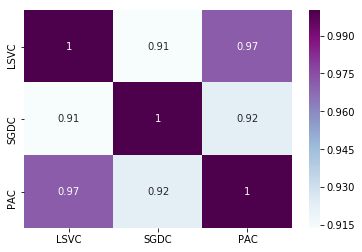

In [192]:
test_LSVC = pd.Series(LSVC_best.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test))), name="LSVC")
test_SGDC = pd.Series(SGDC_best.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test))), name="SGDC")
test_PAC = pd.Series(PAC_best.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test))), name="PAC")

ensemble_results = pd.concat([test_LSVC,test_SGDC,test_PAC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True, cmap = 'BuPu')

Almost the same. We put them together with votingClassifier

In [199]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('linearSVC', LSVC_best), ('SGDC',SGDC_best), ('PAC',PAC_best)],
                           voting='hard', n_jobs=4)

votingC = votingC.fit(X_train_tfidf, y_train)

In [200]:
# get prediction
y_pre = votingC.predict(tfidf_transformer.fit_transform(count_vect.transform(X_test)))
print(metrics.classification_report(y_test, y_pre))

             precision    recall  f1-score   support

          0       0.79      0.85      0.82       107
          1       0.57      0.59      0.58       118
          2       0.64      0.58      0.61       254
          3       0.64      0.77      0.70       575
          4       0.68      0.71      0.70       323
          5       0.71      0.54      0.61       193
          6       0.73      0.66      0.70       327
          7       0.68      0.68      0.68       247
          8       0.90      0.72      0.80       106
          9       0.58      0.57      0.57       522
         10       0.82      0.77      0.79       243
         11       0.68      0.69      0.68       396
         12       0.82      0.85      0.84       203

avg / total       0.69      0.68      0.68      3614



/Users/enzoliu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 2.5 Model Evaluation

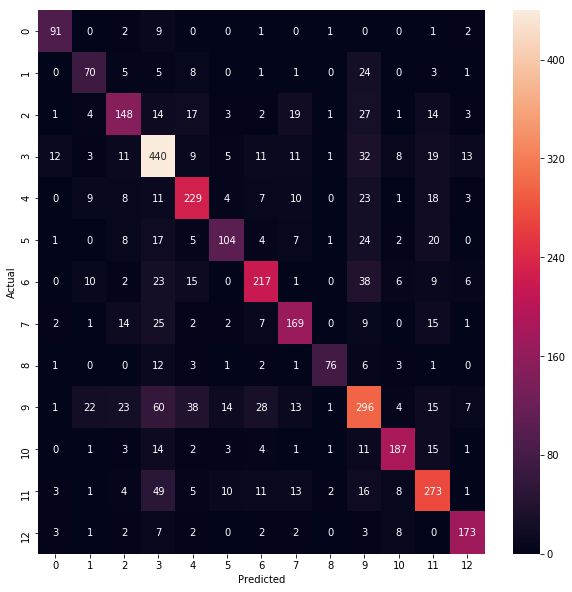

In [201]:
conf_mat = confusion_matrix(y_test, y_pre)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12],
           yticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In this confusion matrix, we can know something important.

- Trump(0) : The model tell it from the rests so well !
- Politique(1): The model confuses it with Société(9).
- Economie(2): The model confuses it with Monde(3), Tech(7), Société(9)
- Monde(3): The model confuses it with Société(9) and Plantète(11)
- Région(4): The model confuses it with Société(9)
- Santé(5): The model confuses it with Société(9) and Plantète(11)
- Culture(6): The model confuses it with Société(9) and Plantète(11)
- Tech(7): The model confuses it with Société(9) and Plantète(11)
- Sport(8): The model tell it from the rests so well !
- Société(9): The model almost can't understand it, it puts this kind of tweets everywhere !
- Afrique(10), Moyen-orient(12): The model tell it from the rests so well !

**In conclusion:** 
- The model is parfait with Trump(0), Sport(8), Afrique(10), Moyen-orient(12)
- The model confuses Plantète(11) with Monde(3), Santé(5), Culture(6) and Tech(7)
- The model is bad for Société(9), it puts this kind of tweets everywhere ! ( Politique 1, Economie 2, Monde 3, Région 4)

# 3. Exporting Model

In [195]:
import pickle

save_classifier = open('tweetClassifier.pickle','wb')
pickle.dump(votingC, save_classifier)
save_classifier.close()

In [196]:
print(os.listdir("./"))

['.DS_Store', 'textClassification.ipynb', '.ipynb_checkpoints', 'tweetClassifier.pickle', 'data']


**We need to save our CountVectorizer and TfidfTransformer, too**

In [197]:
save_count_vect = open("count_vect.pickle", 'wb')
pickle.dump(count_vect, save_count_vect)
save_count_vect.close()
print(os.listdir("./"))

['count_vect.pickle', '.DS_Store', 'tweet_precdict.py', 'textClassification.ipynb', '.ipynb_checkpoints', 'tweetClassifier.pickle', 'data']


In [198]:
save_tfidf_transformer = open("tfidf_transformer.pickle", "wb")
pickle.dump(tfidf_transformer, save_tfidf_transformer)
save_tfidf_transformer.close()
print(os.listdir("./"))

['count_vect.pickle', '.DS_Store', 'tweet_precdict.py', 'textClassification.ipynb', 'tfidf_transformer.pickle', '.ipynb_checkpoints', 'tweetClassifier.pickle', 'data']
